Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [348]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [349]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


In [350]:
data = load_csv_data('csv_data')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


In [351]:
def trim_dataframes_to_shortest(df_list):
    min_length = min(df.shape[0] for df in df_list)
    for i in range(len(df_list)):
        df_list[i] = df_list[i].iloc[:min_length]

In [352]:
trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

Funktion zum Plotten

In [353]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [354]:
compare_acc_gyr(jump_acc,jump_gyr)

In [355]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [356]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })



In [357]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)


In [358]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

In [359]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])

    num_columns = len(filtered_df.columns)
    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        positive_indices = np.where(frequencies > 0)
        
        positive_frequencies = frequencies[positive_indices]
        positive_amplitudes = amplitudes[positive_indices]

        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

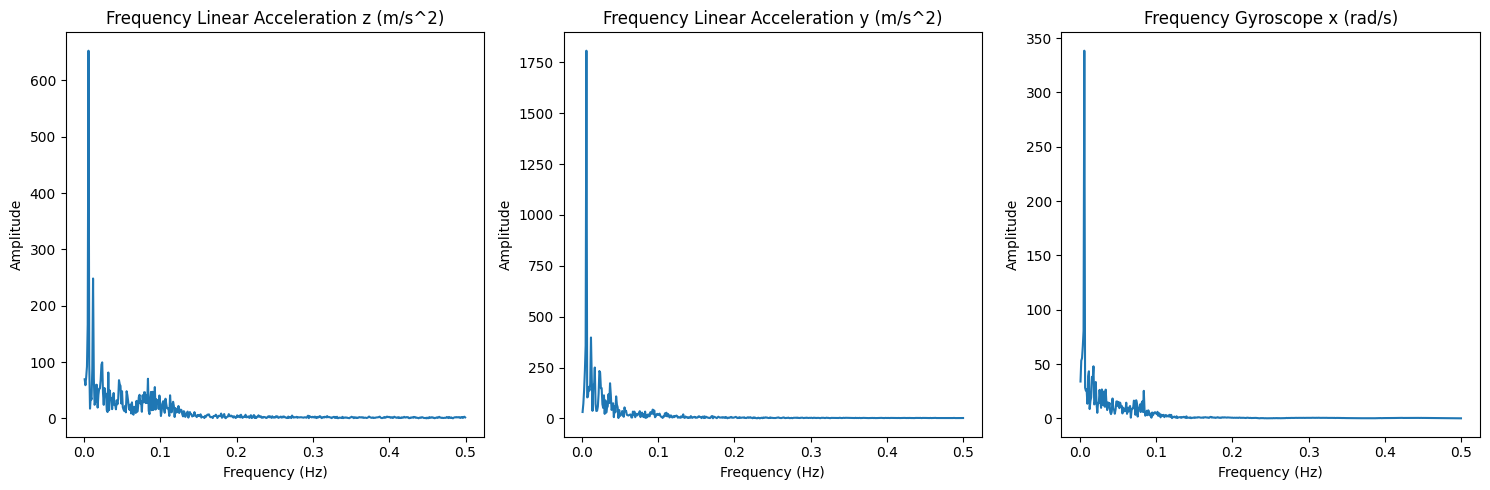

In [360]:
plot_frequencies(squat_df)

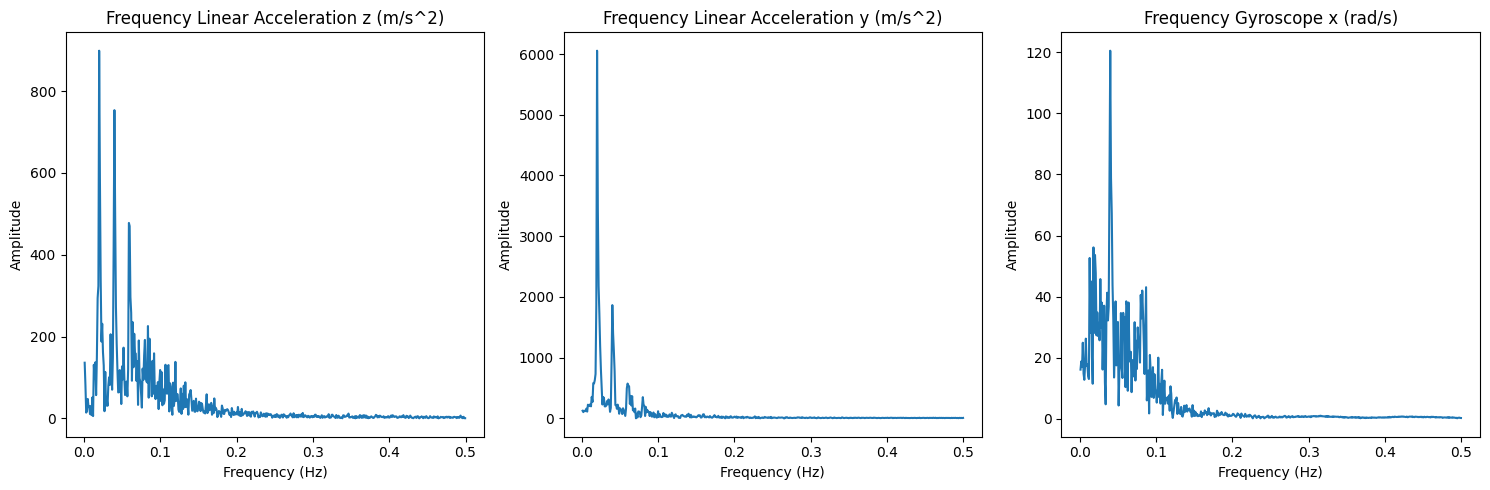

In [361]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

In den Plots ist erkennbar, dass der Großteil der Daten sich im Bereich bis 0,3 Hz befindet. Dies deutet darauf hin, dass 
die wesentlichen Bewegungsinformationen für Aktivitäten wie Kniebeugen und Sprünge in diesem niedrigen Frequenzbereich liegen.
Bei Kniebeugen und Sprüngen handelt es sich um relativ langsame Bewegungen, die durch größere, kontrollierte Muskelbewegungen
gekennzeichnet sind, im Gegensatz zu schnellen, feinen Bewegungen. Die niedrigeren Frequenzen repräsentieren diese langsameren,
großformatigen Bewegungen besser, während höhere Frequenzen tendenziell schnelle, kleine oder zufällige Bewegungen darstellen,
die möglicherweise als Rauschen betrachtet werden können.

In [362]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 4 
    high_cutoff = 0.3

    # Butterworth Hochpassfilter erstellen
    b, a = butter(filter_order, high_cutoff, btype='high', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

In [363]:
filtered_df_sq = filter_frequency(squat_df)

In [364]:
filtered_df_j = filter_frequency(jump_df)

In [365]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [366]:
def plot_normal_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Z'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Gyr_X'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [367]:
plot_df(filtered_df_j)

In [368]:
plot_df(filtered_df_sq)

In [369]:
filtered_df_j_z = filtered_df_j.copy()
# Korrekte Spaltennamen verwenden
filtered_df_j_z['Z_Score_Y'] = stats.zscore(filtered_df_j['Linear Acceleration y (m/s^2)'])
filtered_df_j_z['Z_Score_Z'] = stats.zscore(filtered_df_j['Linear Acceleration z (m/s^2)'])
filtered_df_j_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_j['Gyroscope x (rad/s)']) 
print(filtered_df_j_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_j_z = filtered_df_j_z[(abs(filtered_df_j_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014226                       1.155463                       1.423950   
1  0.024235                       1.145252                       3.481231   
2  0.034215                       1.092266                       5.339325   
3  0.044224                       1.534986                       6.876205   
4  0.054204                       2.060904                       8.011739   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0            -0.217730   0.118320   0.365524      -0.450274  
1            -0.216169   0.277931   0.362208      -0.446900  
2            -0.214621   0.422088   0.344998      -0.443556  
3            -0.213087   0.541324   0.488792      -0.440242  
4            -0.211567   0.629422   0.659609      -0.436959  


In [370]:
filtered_df_sq_z = filtered_df_sq.copy()
# Korrekte Spaltennamen verwenden
filtered_df_sq_z['Z_Score_Y'] = stats.zscore(filtered_df_sq['Linear Acceleration y (m/s^2)'])
filtered_df_sq_z['Z_Score_Z'] = stats.zscore(filtered_df_sq['Linear Acceleration z (m/s^2)'])
filtered_df_sq_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_sq['Gyroscope x (rad/s)']) 
print(filtered_df_sq_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_sq_z = filtered_df_sq_z[(abs(filtered_df_sq_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014470                      -0.087995                       0.193291   
1  0.024510                      -0.110033                       0.037491   
2  0.034490                      -0.123475                      -0.094475   
3  0.044499                      -0.126524                      -0.135174   
4  0.054448                      -0.117025                      -0.065156   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0             0.108063   0.074442  -0.073419       0.182567  
1             0.103144   0.019228  -0.092668       0.173532  
2             0.098214  -0.027539  -0.104410       0.164477  
3             0.093274  -0.041963  -0.107074       0.155403  
4             0.088323  -0.017149  -0.098776       0.146310  


Außreißer gefiltert

In [371]:
plot_normal_df(filtered_df_j_z)

In [372]:
plot_df(filtered_df_sq_z)

Normalisieren

In [373]:
# Auswählen der Features
features_to_scale = ['Z_Score_Y', 'Z_Score_Z', 'Z_Score_Gyr_X']
# Initialisierung Min-Max Scaler auf gewünschte Werte
scaler = MinMaxScaler((-1,1))

# Anwendung Min-Max Scaler auf ausgewählte Spalten
filtered_df_sq_z[features_to_scale] = scaler.fit_transform(filtered_df_sq_z[features_to_scale])

In [374]:
# Auswählen der Features
features_to_scale = ['Z_Score_Y', 'Z_Score_Z', 'Z_Score_Gyr_X']
# Initialisierung Min-Max Scaler auf gewünschte Werte
scaler = MinMaxScaler((-1,1))

# Anwendung Min-Max Scaler auf ausgewählte Spalten
filtered_df_j_z[features_to_scale] = scaler.fit_transform(filtered_df_j_z[features_to_scale])

In [375]:
plot_normal_df(filtered_df_sq_z)

In [376]:
plot_normal_df(filtered_df_j_z)

In [377]:
filtered_df_sq_z['Label'] = 'squat'
filtered_df_j_z['Label'] = 'jump'
combined_df = pd.concat([filtered_df_sq_z, filtered_df_j_z], ignore_index=True)

In [378]:
combined_df.head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X,Label
0,0.014470,-0.087995,0.193291,0.108063,-0.137198,-0.116740,0.151279,squat
1,0.024510,-0.110033,0.037491,0.103144,-0.161463,-0.123812,0.146754,squat
2,0.034490,-0.123475,-0.094475,0.098214,-0.182016,-0.128126,0.142219,squat
3,0.044499,-0.126524,-0.135174,0.093274,-0.188355,-0.129104,0.137673,squat
4,0.054448,-0.117025,-0.065156,0.088323,-0.177450,-0.126056,0.133119,squat


In [379]:
window_size = 80 #Bei Bedarf anpassen
overlap = 50 #Bei Bedarf anpassen

#Liste initiieren für Fenster
windows = []

#Für jedes Fenster in den Daten neuen Dataframe erstellen, der in Liste abgelegt wird 
for i in range(0, len(combined_df), window_size - overlap):
    window = combined_df.iloc[i:i+window_size]
    windows.append(window)

#Ersten Dataframe in der Liste ausgeben lassen 
print(windows[0].head())
#Anzahl Datenpunkte des ersten Dataframes ausgeben lassen 
print(len(windows[0]))
#Spalten des ersten Dataframes ausgeben lassen 
#print(windows[0].columns)

#Ausgeben lassen wie viele Dataframes also Fenster entstanden sind 
print (len(windows))


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014470                      -0.087995                       0.193291   
1  0.024510                      -0.110033                       0.037491   
2  0.034490                      -0.123475                      -0.094475   
3  0.044499                      -0.126524                      -0.135174   
4  0.054448                      -0.117025                      -0.065156   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  Label  
0             0.108063  -0.137198  -0.116740       0.151279  squat  
1             0.103144  -0.161463  -0.123812       0.146754  squat  
2             0.098214  -0.182016  -0.128126       0.142219  squat  
3             0.093274  -0.188355  -0.129104       0.137673  squat  
4             0.088323  -0.177450  -0.126056       0.133119  squat  
80
67


In [380]:
windows[0].head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X,Label
0,0.014470,-0.087995,0.193291,0.108063,-0.137198,-0.116740,0.151279,squat
1,0.024510,-0.110033,0.037491,0.103144,-0.161463,-0.123812,0.146754,squat
2,0.034490,-0.123475,-0.094475,0.098214,-0.182016,-0.128126,0.142219,squat
3,0.044499,-0.126524,-0.135174,0.093274,-0.188355,-0.129104,0.137673,squat
4,0.054448,-0.117025,-0.065156,0.088323,-0.177450,-0.126056,0.133119,squat


In [384]:
# Leere Liste erstellen, um Features zu speichern
feature_list = []

# Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
for window in windows:
    acc_y = window['Z_Score_Y']
    acc_z = window['Z_Score_Z']
    gyro_x = window['Z_Score_Gyr_X']

    # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
    feature_list.append({
        'acc_y_peak': acc_y.max(),
        'acc_y_std_dev': acc_y.std(),
        'acc_y_variance': acc_y.var(),
        'acc_y_signal_energy': np.sum(acc_y**2),
    })

feature_df = pd.DataFrame(feature_list)

print(feature_df.head())


   acc_y_peak  acc_y_std_dev  acc_y_variance  acc_y_signal_energy
0   -0.113436       0.231786        0.053725            11.649618
1    0.228887       0.287895        0.082884            16.360952
2    0.360510       0.389549        0.151748            15.827949
3    0.637224       0.308032        0.094884            10.095443
4    0.637224       0.325158        0.105728            10.006250


Clustering

In [385]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels

# Gib das aktualisierte DataFrame mit Clusterzuordnungen aus.
#print(feature_df.head())
feature_df.columns


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Index(['acc_y_peak', 'acc_y_std_dev', 'acc_y_variance', 'acc_y_signal_energy',
       'Cluster'],
      dtype='object')

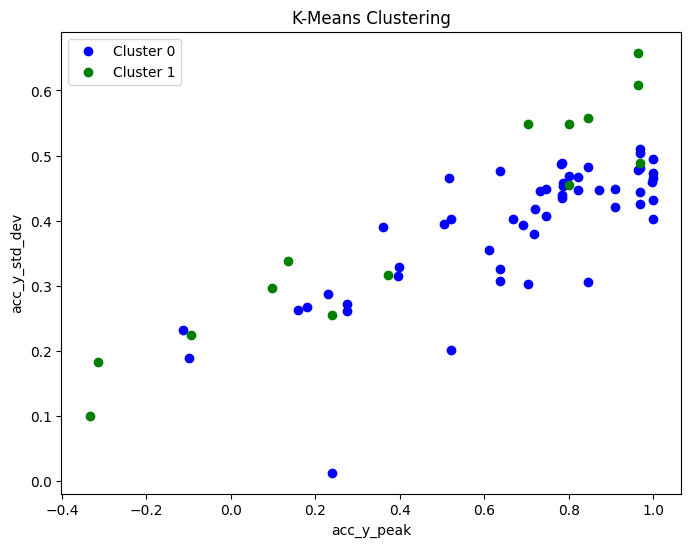

In [386]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['acc_y_peak'], cluster_data['acc_y_std_dev'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('acc_y_peak')
plt.ylabel('acc_y_std_dev')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()
